## Prepare Notebook

In [27]:
import arviz as az
from datetime import datetime
from itertools import chain
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import numpy.typing as npt
import pandas as pd
import pymc as pm
import pymc.sampling_jax
import seaborn as sns
from scipy.special import expit


plt.style.use("bmh")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Generate Data

In [28]:
seed: int = sum(map(ord, "retention"))
rng: np.random.Generator = np.random.default_rng(seed=seed)


class CohortDataGenerator:
    def __init__(
        self,
        rng: np.random.Generator,
        start_cohort: str,
        n_cohorts,
        user_base: int = 10_000,
    ) -> None:
        self.rng = rng
        self.start_cohort = start_cohort
        self.n_cohorts = n_cohorts
        self.user_base = user_base

    def _generate_cohort_labels(self) -> pd.DatetimeIndex:
        return pd.period_range(
            start="2020-01-01", periods=self.n_cohorts, freq="M"
        ).to_timestamp()

    def _generate_cohort_sizes(self) -> npt.NDArray[np.int_]:
        ones = np.ones(shape=self.n_cohorts)
        trend = ones.cumsum() / ones.sum()
        return (
            (self.user_base * trend * rng.gamma(shape=1, scale=1, size=self.n_cohorts))
            .round()
            .astype(int)
        )

    def _generate_dataset_base(self) -> pd.DataFrame:
        cohorts = self._generate_cohort_labels()
        n_users = self._generate_cohort_sizes()
        data_df = pd.merge(
            left=pd.DataFrame(data={"cohort": cohorts, "n_users": n_users}),
            right=pd.DataFrame(data={"period": cohorts}),
            how="cross",
        )
        data_df["age"] = (data_df["period"].max() - data_df["cohort"]).dt.days
        data_df["cohort_age"] = (data_df["period"] - data_df["cohort"]).dt.days
        data_df = data_df.query("cohort_age >= 0")
        return data_df

    def _generate_retention_rates(self, data_df: pd.DataFrame) -> pd.DataFrame:
        data_df["retention_true_mu"] = (
            -data_df["cohort_age"] / (data_df["age"] + 1)
            + 0.8 * np.cos(2 * np.pi * data_df["period"].dt.dayofyear / 365)
            + 0.5 * np.sin(2 * 3 * np.pi * data_df["period"].dt.dayofyear / 365)
            - 0.5 * np.log1p(data_df["age"])
            + 0.5
        )
        data_df["retention_true"] = expit(data_df["retention_true_mu"])
        return data_df

    def _generate_user_history(self, data_df: pd.DataFrame) -> pd.DataFrame:
        data_df["n_active_users"] = rng.binomial(
            n=data_df["n_users"], p=data_df["retention_true"]
        )
        data_df["n_active_users"] = np.where(
            data_df["cohort_age"] == 0, data_df["n_users"], data_df["n_active_users"]
        )
        return data_df

    def run(
        self,
    ) -> pd.DataFrame:
        return (
            self._generate_dataset_base()
            .pipe(self._generate_retention_rates)
            .pipe(self._generate_user_history)
        )


In [29]:
cohort_generator = CohortDataGenerator(rng=rng, start_cohort="2020-01-01", n_cohorts=35)
data_df = cohort_generator.run()

data_df.head()

,cohort,n_users,period,age,cohort_age,retention_true_mu,retention_true,n_active_users
0,2020-01-01,206,2020-01-01,1035,0,-2.145870,0.104718,206
1,2020-01-01,206,2020-02-01,1035,31,-1.821493,0.139255,31
2,2020-01-01,206,2020-03-01,1035,60,-2.635769,0.066872,18
3,2020-01-01,206,2020-04-01,1035,91,-3.569352,0.027402,2
4,2020-01-01,206,2020-05-01,1035,121,-3.483719,0.029779,8


In [30]:
data_df["retention"] = data_df["n_active_users"] / data_df["n_users"]

## EDA

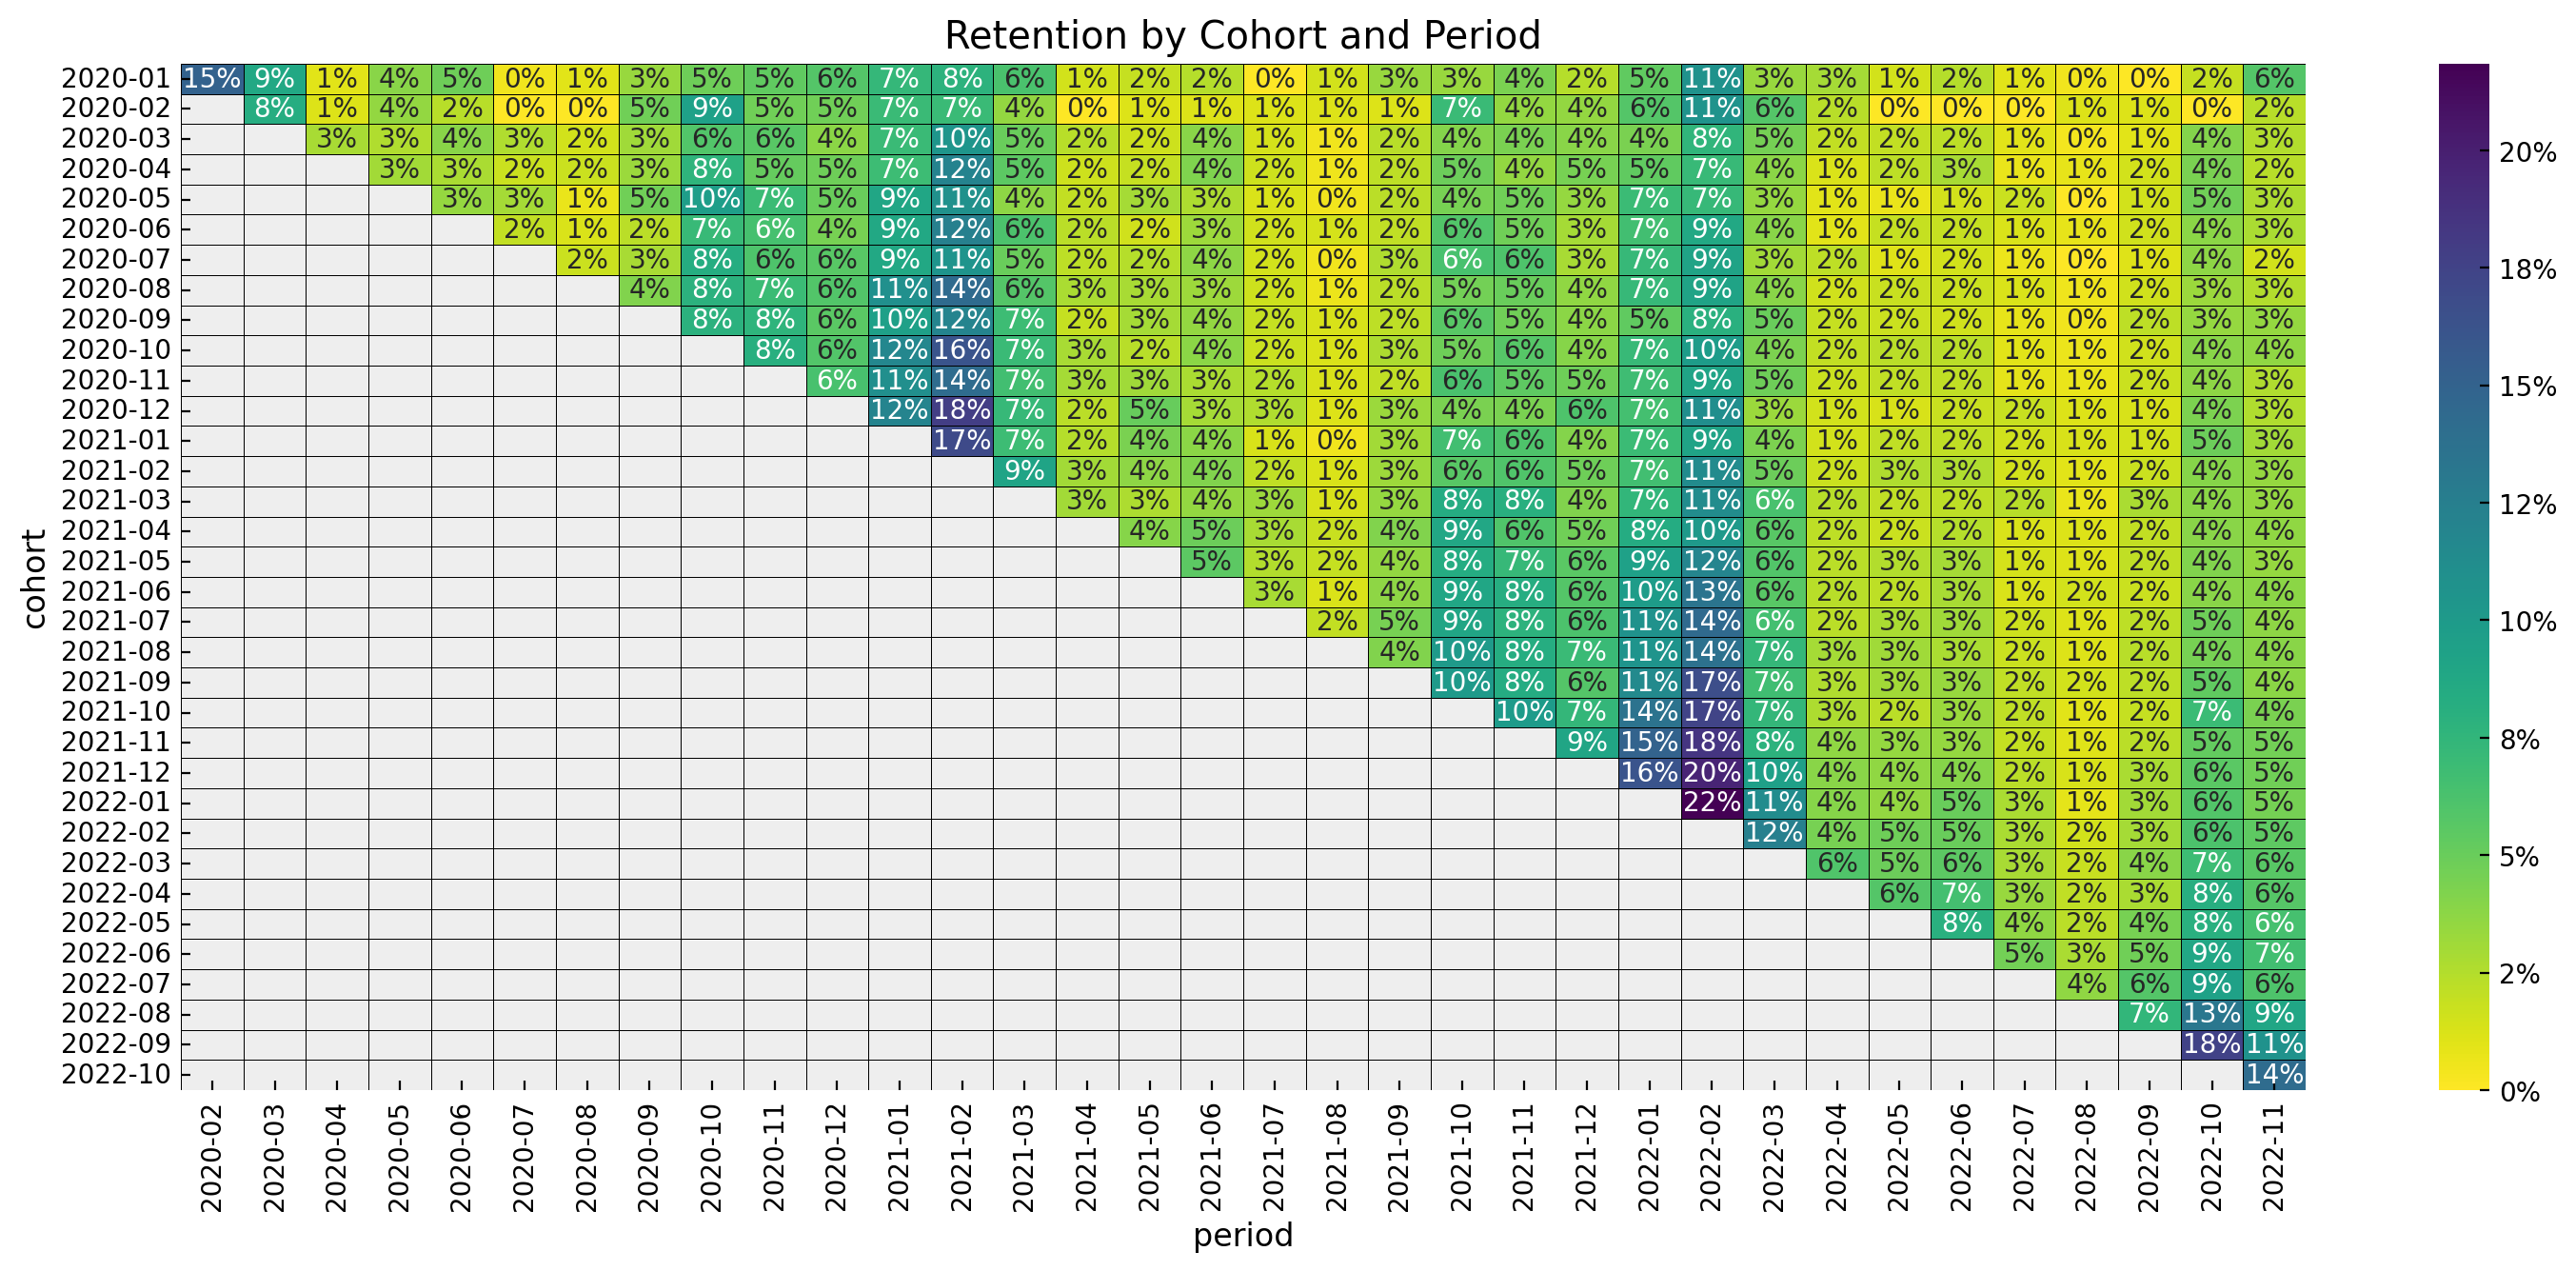

In [35]:
fig, ax = plt.subplots(figsize=(18, 7))

fmt = lambda y, _: f"{y :0.0%}"

(
    data_df.assign(
        cohort=lambda df: df["cohort"].dt.strftime("%Y-%m"),
        period=lambda df: df["period"].dt.strftime("%Y-%m"),
    )
    .query("cohort_age != 0")
    .filter(["cohort", "period", "retention"])
    .pivot(index="cohort", columns="period", values="retention")
    .pipe(
        (sns.heatmap, "data"),
        cmap="viridis_r",
        linewidths=0.2,
        linecolor="black",
        annot=True,
        fmt="0.0%",
        cbar_kws={"format": mtick.FuncFormatter(fmt)},
        ax=ax,
    )
)

ax.set_title("Retention by Cohort and Period");

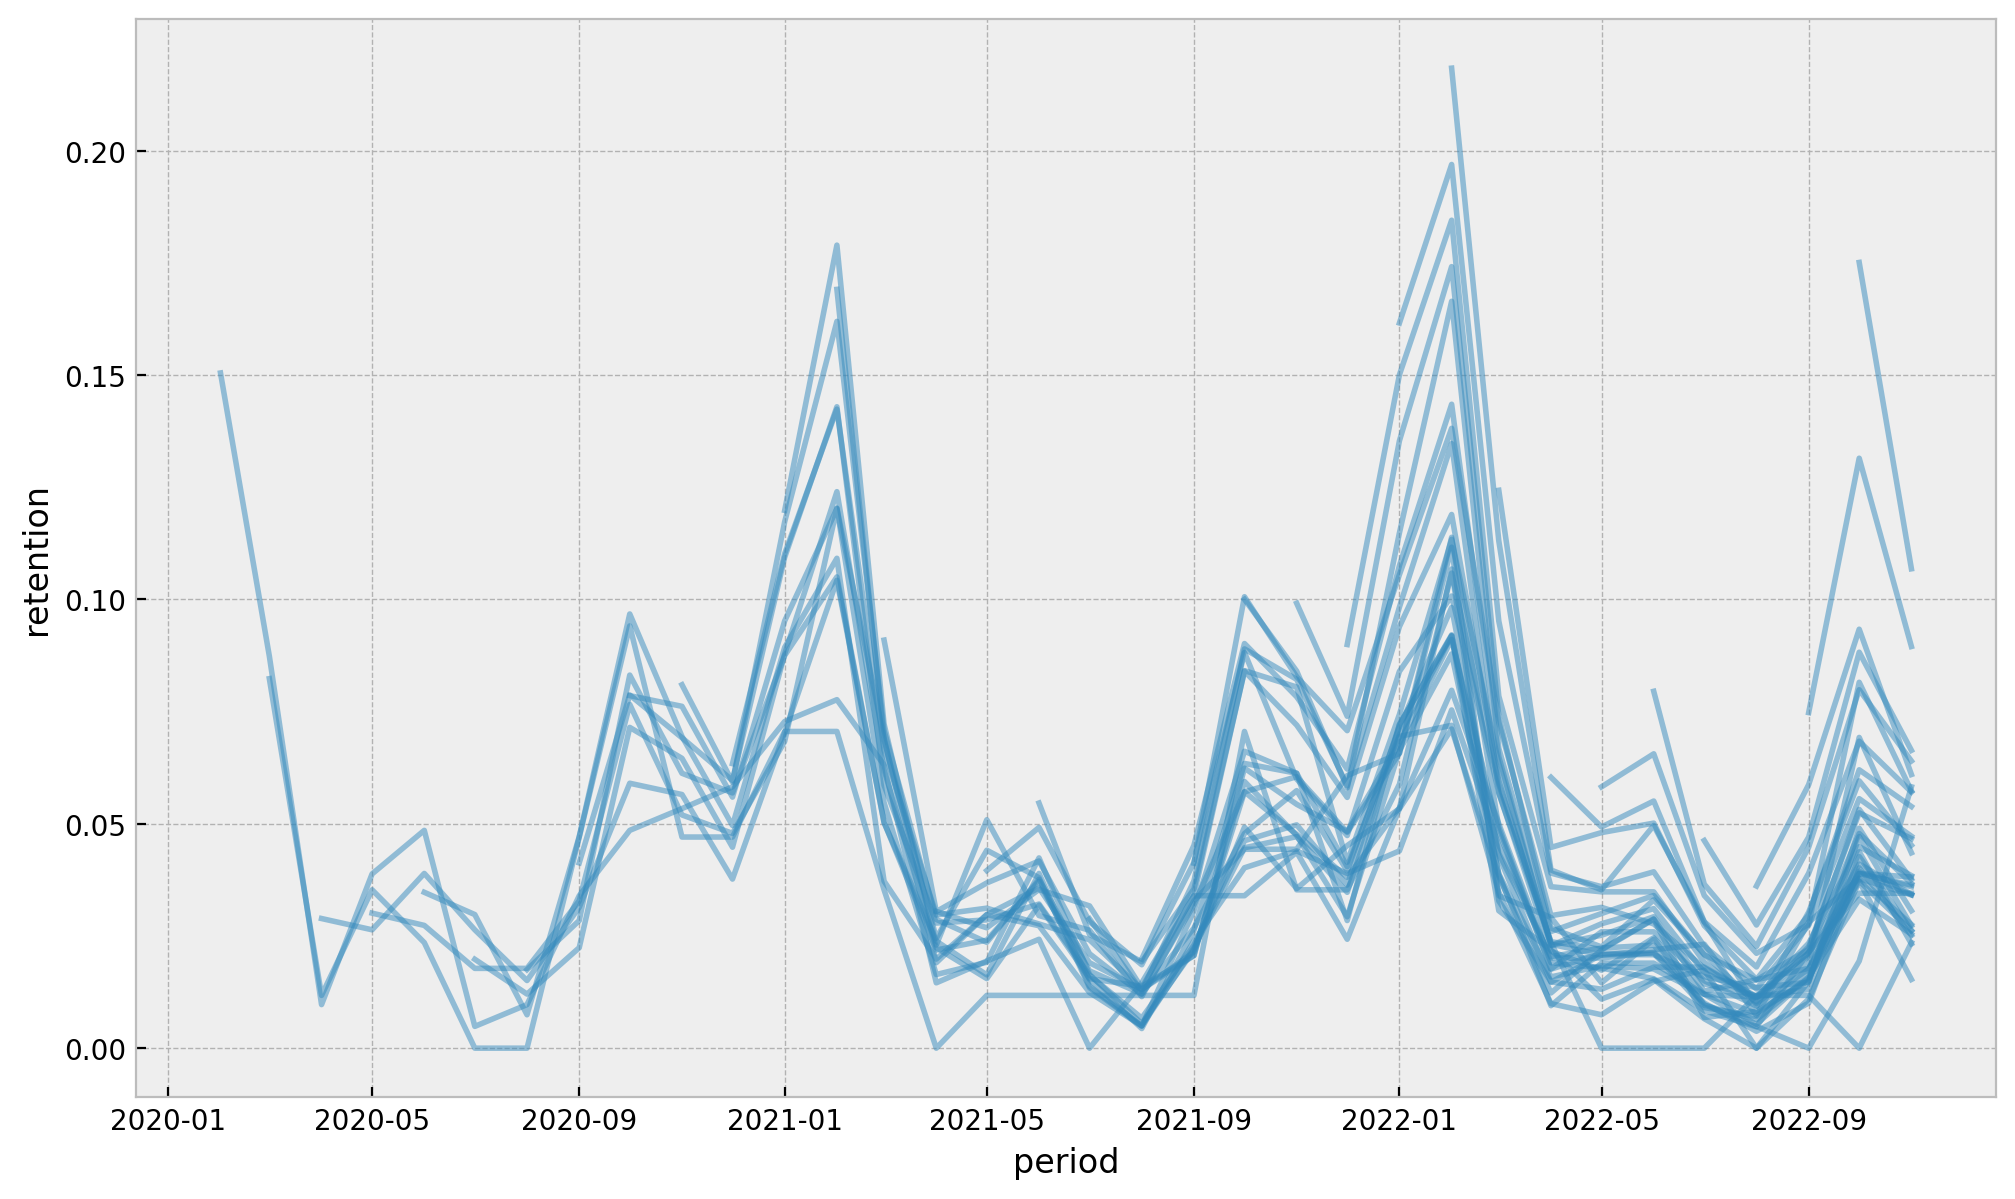

In [61]:
for cohort in data_df["cohort"].unique():
    mask = f"cohort_age > 0 and cohort == '{cohort}'"
    if not (cohort_df := data_df.query(mask)).empty:
        sns.lineplot(x="period", y="retention", color="C0", alpha=0.5, data=cohort_df)

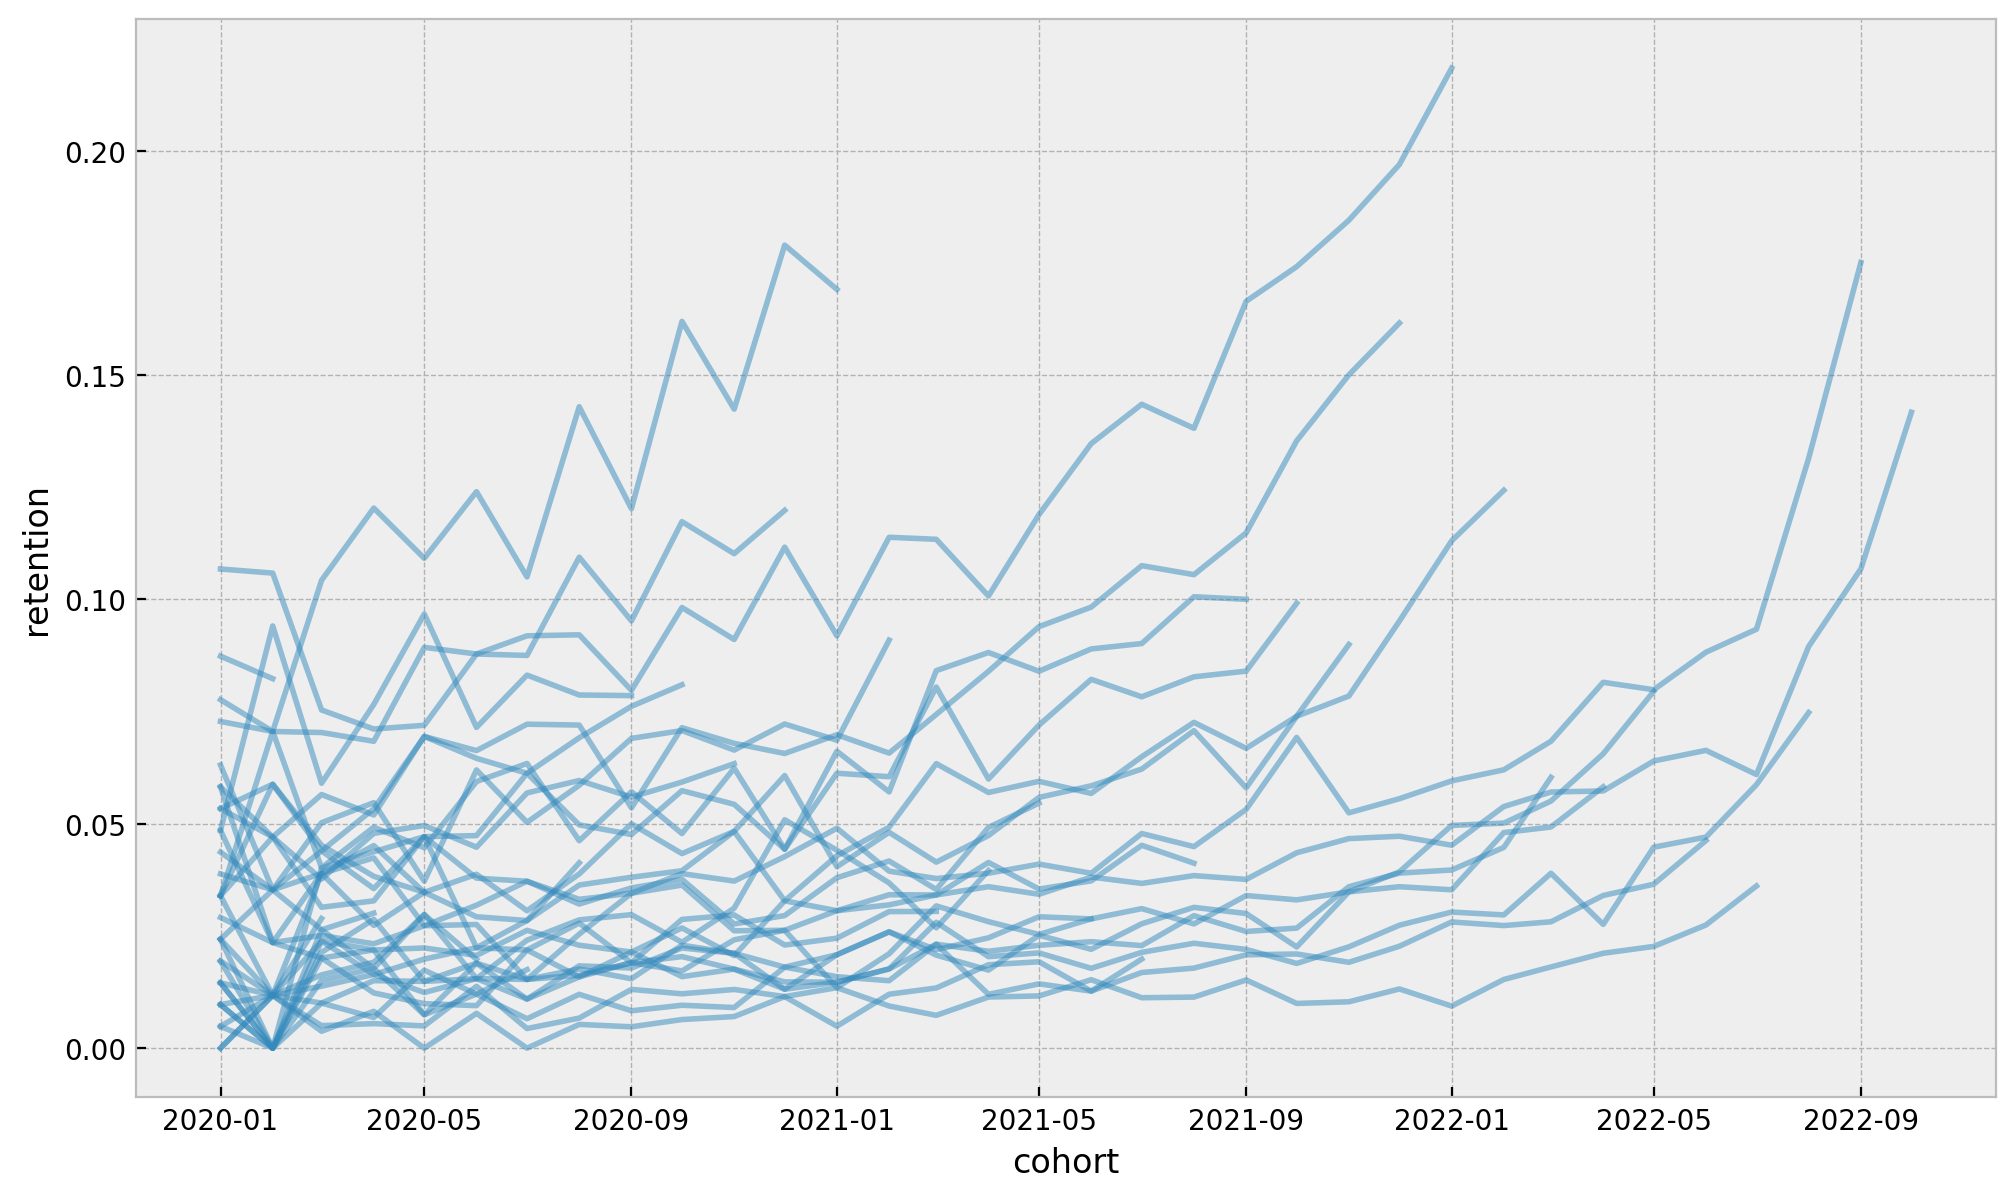

In [64]:
for period in data_df["period"].unique():
    mask = f"cohort_age > 0 and period == '{period}'"
    if not (cohort_df := data_df.query(mask)).empty:
        sns.lineplot(x="cohort", y="retention", color="C0", alpha=0.5, data=cohort_df)